In [1]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5a2ba000 @  0x7f81f05ab1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 2.0MB 8.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from matplotlib import pyplot as plt
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

In [0]:
from torch.nn.parameter import Parameter
import pdb

In [0]:
import torchvision
import os
import gzip
import tarfile
import gc
import time

from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

In [0]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
 
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
 
  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
 
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))
 
 
  def __getitem__(self,index):
    img = self.dataset_folder[index]
    
    label = self.label_folder[index]
    
    return img[0],label[0][0]
 
  def __len__(self):
    return len(self.dataset_folder)
 

In [0]:
A = CancerDataset(root='content/drive/my_drive/colab')

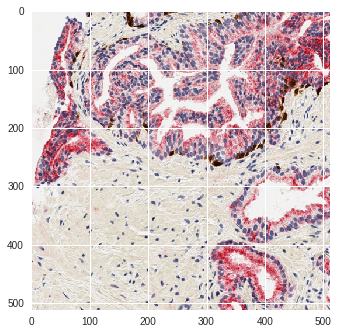

In [6]:
image = A[0][0]
plt.figure()
plt.imshow(image.numpy().transpose(1,2, 0)) # subtract 255
plt.show()

# Build Framework of Neural Network

In [0]:
# conv network block that does each conv block going upward in U diagram
class Upsample(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(Upsample, self).__init__()
    self.upsample = nn.Sequential(nn.ConvTranspose2d(in_channel, out_channel, kernel_size=4, stride=2, padding=1), nn.ReLU()) #this might get you the right shape at the end
    # input_size*stride = max(filter size - stride, 0) - not useful
    # use a 2 x 2
    # outchannel is 1/2 of input channel 
    
  def forward(self, input):
    return self.upsample(input)
  
# conv network block that does each conv block going downward in U diagram
class Inner_conv2d(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(Inner_conv2d, self).__init__()

    self.inner_conv2d = nn.Sequential(nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1), nn.ReLU(),
                                   nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1), nn.ReLU(),
                                  nn.BatchNorm2d(out_channel))
    
  def forward(self, input):
    return self.inner_conv2d(input)
  

class CancerDetection(nn.Module):
  def __init__(self, dataset):
    super(CancerDetection, self).__init__()
 
    self.conv1 = Inner_conv2d(3,64)
    self.conv2 = Inner_conv2d(64,128)
    self.conv3 = Inner_conv2d(128,256)
    self.conv4 = Inner_conv2d(256,512)
    self.conv5 = Inner_conv2d(512,1024)
    
    self.max_pool = nn.MaxPool2d(2)
    
    self.upsample54 = Upsample(1024, 512)
    self.upsample43 = Upsample(512, 256)
    
    self.upsample32 = Upsample(256, 128)
    self.upsample21 = Upsample(128, 64)
    
    self.conv6 = Inner_conv2d(1024, 512)
    self.conv7 = Inner_conv2d(512, 256)
    self.conv8 = Inner_conv2d(256, 128)
    self.conv9 = Inner_conv2d(128, 64)
    
    self.conv10 = nn.Sequential(nn.Conv2d(64, 2, 1, 1, 0), nn.Sigmoid())
 
  def forward(self, input):
    # Moving down the U
    conv1_out = self.conv1(input)  
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))
    conv5_out = self.conv5(self.max_pool(conv4_out))
    
    # Moving the U
    conv5_up_concat = torch.cat((self.upsample54(conv5_out), conv4_out),1)
    conv6_out = self.conv6(conv5_up_concat)
    
    conv4_up_concat = torch.cat((self.upsample43(conv6_out), conv3_out),1)
    conv7_out = self.conv7(conv4_up_concat)
    
    conv3_up_concat = torch.cat((self.upsample32(conv7_out), conv2_out),1)
    conv8_out = self.conv8(conv3_up_concat)
    
    conv2_up_concat = torch.cat((self.upsample21(conv8_out), conv1_out),1)
    conv9_out = self.conv9(conv2_up_concat)
    
    conv10_out = self.conv10(conv9_out)

    return conv10_out 

In [0]:
# helps with memory management
def scope():
  try:
    #your code for calling dataset and dataloader
    start_time = time.time()
    
    train_dataset = CancerDataset(root='content/drive/my_drive/colab', train=True) 
    val_dataset = CancerDataset(root='content/drive/my_drive/colab', train=False) 
    
    
    model = CancerDetection(train_dataset)
    
    model.cuda() # converts to gpu
    objective = nn.CrossEntropyLoss() # loss function
    optimizer = optim.Adam(model.parameters(), lr = 1e-4) # model.parameters(): recursive called list of all params
    train_loader = DataLoader(train_dataset, # parellelizes  
                              batch_size=2, # assigns batch size
                              pin_memory=True, shuffle= True) # each batch a diff location in gpu

    # val set
    val_loader = DataLoader(val_dataset, 
                          batch_size=2, 
                          pin_memory=True, shuffle= True)  
 
    gc.collect()
    print(torch.cuda.memory_allocated(0) / 1e9)
 
    #for epochs:
    #  Call your model,loss,and accuracy
    ave_loss_per_epoch = []
    ave_train_acc_per_epoch = []
    validations = []

    for epoch in range(10):
      losses = []
      train_accuracy = []

      loop = tqdm(total=len(train_loader), position=0, leave=False)

      for batch, (x, y_truth) in enumerate(train_loader): # batch of x's and y's    
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True).long() # move data to gpu 

        optimizer.zero_grad()
        y_hat = model(x) # x is now a batch

        train_loss = objective(y_hat, y_truth.long()) # loss is a class, with a func called on it
        train_loss.backward()

        losses.append(train_loss.item()) # goal for loss: train until this decreases    
        accuracy = (y_hat.argmax(1) == y_truth.long()).float().mean().item() #score function
        train_accuracy.append(accuracy)
        
        loop.set_description('epoch:{},loss:{:.4f}, accuracy:{:.3f}'.format(epoch, train_loss.item(), accuracy)) # .item returns float number  
        loop.update(1) # updates the loop 

        optimizer.step()

        if batch % 300 == 0:
          val = np.mean([objective(model(x.cuda()), y.cuda().long()).item() for x, y in val_loader])
          validations.append((len(losses), val)) 
          
      ave_loss_per_epoch.append(np.average(losses))
      ave_train_acc_per_epoch.append(np.average(train_accuracy))
    
    print("Final time:", time.time() - start_time)
    return model, ave_loss_per_epoch, ave_train_acc_per_epoch
 
  except:
    __ITB__()
    print("Final time:", time.time() - start_time)
    return model, ave_loss_per_epoch, ave_train_acc_per_epoch


In [9]:
final_model, ave_loss_per_epoch, ave_train_acc_per_epoch = scope()

  0%|          | 0/671 [00:00<?, ?it/s]

0.1576064


epoch:9,loss:0.4288, accuracy:0.884: 100%|██████████| 671/671 [25:58<00:00,  2.02s/it]

Final time: 15513.181168317795


# Training Loss vs. Training Accuracy

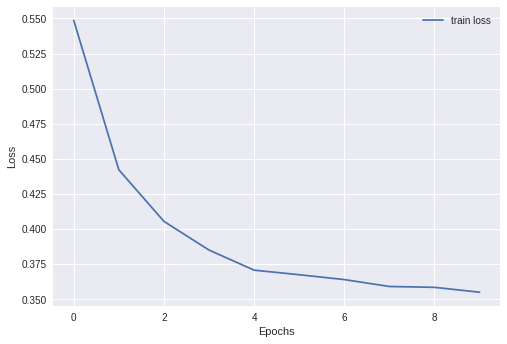

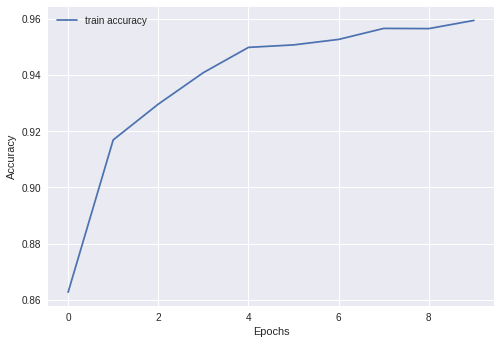

In [10]:
  x_linspace = np.arange(10)
  
  plt.plot(x_linspace,ave_loss_per_epoch, label='train loss')
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.plot(x_linspace,ave_train_acc_per_epoch, label='train accuracy')
  plt.xlabel('Epochs')
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

# Cancer Detection Sample

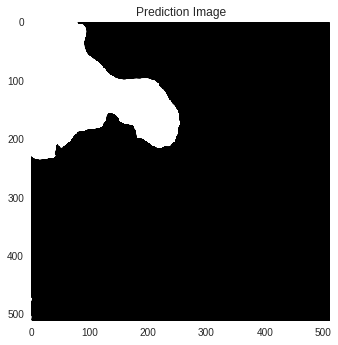

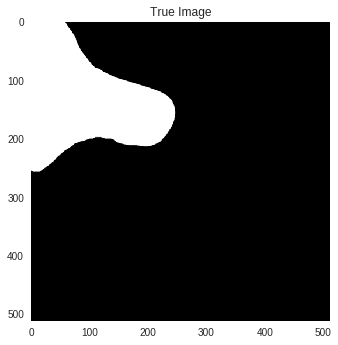

In [18]:
val_dataset = CancerDataset(root='content/drive/my_drive/colab', train=False)
val_loader = DataLoader(val_dataset, 
                          batch_size=2, 
                          pin_memory=True)  

for batch, (x, y_truth) in enumerate(val_loader):
  if batch == 86: # val_loader takes 2 per batch - 86 = 172/2    
    final_test_img = x.cuda()
    
pred_final = final_model(final_test_img)[0]
final_test_label = val_dataset[172][1]

#pred 
plt.figure()
plt.imshow(pred_final[0].cpu().detach().numpy()) # subtract 255
plt.title("Prediction Image")
plt.grid(False)
plt.show()


#true label
plt.figure()
plt.imshow(1 - final_test_label) # subtract 255
plt.title("True Image")
plt.grid(False)
plt.show()